In [22]:
import sklearn
from sysid.subspace_cupy_fp16 import subspace_det_algo1, prbs, nrms, symmetric_mean_absolute_percentage_error, \
    index_of_agreement, mean_absolute_percentage_error, mean_absolute_scaled_error
from sysid.ss_cupy_fp16 import StateSpaceDiscreteLinear, StateSpaceDataList, StateSpaceDataArray
from sklearn.metrics import r2_score
import time
import pandas as pd
import cupy as np
import numpy
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA

Virtual Data:

In [23]:
tf = 20  # 365 * 5
dt = 1
plot_stuff = True

u_dimensions = 2
y_dimensions = 2

data_u = np.random.randn(u_dimensions, tf)  # 40 * 45
# data_y = np.random.randn(3, tf)  # 40 * 45
white_noise = 0.1 *  np.random.randn(y_dimensions, tf)
uniform_noise = 0.1 *  np.random.rand(y_dimensions, tf)
data_y2 = 80 + 30 * (data_u[0:y_dimensions,:] + white_noise + uniform_noise) # 40 * 45

# Regularize data
data_y = (data_y2 - np.mean(data_y2)) / np.std(data_y2)

data_y.shape

(2, 20)

In [24]:
# TODO:
# 1. time-series split
# 2. 3 days ahead predict
# 3. Island transpeciation search
# 4. 50% MSE + 50% residuals corr & autocorr error

S&P 500 DATA:

In [25]:
days = tf = 30 # Total simulation days
total_days = tf * 2

total_top_correlated = 300 # Max (correlated) total input ticker count

days_fill_range = days
time_step = dt = 1  # Time-step scale (1 day)

plot_stuff = True

Read CSV:

In [26]:
df1 = pd.read_csv('sp500_joined_closes.csv')
print(df1.shape)

(2615, 506)


In [27]:
df1 = pd.read_csv('C:/Users/temp3rr0r/PycharmProjects/Financial Forecasting/top_crypto_world_indices_tickers.csv')
print(df1.shape)
# df1 = df1.dropna(axis='columns')  # Drop columns with NA

(3698, 1454)


In [28]:
df1 = df1.set_index("Date")
print(df1.shape)

(3698, 1453)


In [29]:
df1 = df1.drop_duplicates()
# df3 = df2.tail(365*9)
print(df1.shape)

(3698, 1453)


In [30]:
df1 = df1.astype(float)
print(df1.shape)

(3698, 1453)


In [31]:
df = df1.tail(total_days)
min_max_df = (df-df.min())/(df.max()-df.min())
standardized_df = (df-df.mean())/(df.std())
normalized_df = standardized_df
print(normalized_df.shape)
normalized_df.head(1)

(60, 1453)


,COTY,ADT,UTL,LKQ,MHK,JHMF,HSFNX,COP,CTL,EURCHF=X,...,SRPT,USB-PM,CUK,AOS,WFC,^AXJO,TAP-A,NJR,PKG,^TA125.TA
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-17,1.107546,-0.962408,2.177621,-1.548557,-0.759905,-0.656352,-0.641283,-1.678858,0.161691,NaN,...,-1.100057,1.508462,-0.597882,-0.890687,0.397139,-0.278626,-2.080228,-0.105879,-0.820481,NaN


In [32]:
normalized_df = normalized_df.interpolate(limit=days_fill_range)
normalized_df = normalized_df.bfill(limit=days_fill_range).ffill(limit=days_fill_range)
# y_labels = ["MSFT", "AMD", "AAPL", "INTC"]
# y_labels = ["BTC-USD", "LTC-USD", "ETH-USD", "BCH-USD"]  # BCH, LTC
y_labels =  ["ETH-USD","XRP-USD","BTC-USD","LTC-USD"]
# normalized_df = normalized_df.drop(['BTCUSD=X'])
# y_labels = ["MSFT"]  # BCH, LTC

In [33]:
normalized_df = normalized_df.dropna(axis='columns')  # Drop columns with NA
print(normalized_df.shape)

(60, 1444)


In [34]:
# Correlate only the TRAINING data (time-steps), not the TEST data... 
# 'pearson’ (linear only), monotonic: ‘kendall’ O(n^2), ‘spearman’ O(n log n)
corr0 = normalized_df.tail(total_days).head(tf).corr(method="spearman") # .abs()  # Don't allow negative correlations
corr1 = corr0[corr0 <0.99999]  # Remove correlations == 100%
corr2 = corr1[corr1>-0.3]  # Remove half correlated

In [35]:
corr3 = corr2.unstack().sort_values(kind="quicksort", ascending=False).drop_duplicates() # Sort by most correlated
corr3 = corr3.drop_duplicates()

In [36]:
u_labels = []  # Add the top correlated tickers to the inputs
for y_label in y_labels:
    u_labels = u_labels + corr3[y_label].head(int(total_top_correlated/len(y_labels))).index.tolist()
    
u_labels = list(dict.fromkeys(u_labels))  # Remove duplicate tickers
for y_label in y_labels:  # Remove output tickers from inputs
    if y_label in u_labels:
        u_labels.remove(y_label)

if 'ETHUSD=X' in u_labels:
    u_labels.remove('ETHUSD=X')  # Remove ETH and BTC...
if 'BTCUSD=X' in u_labels:    
    u_labels.remove('BTCUSD=X')

print("NaNs?", normalized_df[u_labels + y_labels].isnull().values.any())

print("u_labels: {}".format(u_labels))
print("len(u_labels): {}".format(len(u_labels)))
normalized_df[u_labels].tail(total_days).head(tf).head(1)

# data_u = normalized_df[u_labels].tail(tf).values.T
# data_y = normalized_df[y_labels].tail(tf).values.T

data_u = normalized_df[u_labels].tail(total_days).head(tf).values.T
data_y = normalized_df[y_labels].tail(total_days).head(tf).values.T

test_data_u = normalized_df[u_labels].tail(tf).values.T
test_data_y = normalized_df[y_labels].tail(tf).values.T

u_dimensions = len(u_labels)
y_dimensions = len(y_labels)

NaNs? False
u_labels: ['LBTYK', 'BAC-PC', 'CHT', 'KEP', 'X', 'WFC-PP', 'AUDUSD=X', 'BAC-PK', 'NMK-PC', 'MORT', 'LSXMB', 'RRC', 'CTA-PA', 'GS-PD', 'CTA-PB', 'BSM', 'MKC-V', 'FRESX', 'VNO-PK', 'ZN=F', 'CNY=X', 'BML-PL', 'CCU', 'LFC', 'WUBA', 'RAANX', 'SPKE', 'DEI', 'CMS-PB', 'FPVSX', 'WFC-PN', 'WFC-PV', 'DLR-PJ', 'GLIBP', 'ATGE', 'KEN', 'MS-PA', 'GRUB', 'HKD=X', 'COF-PF', 'PFPFX', 'SPG-PJ', 'SLG-PI', 'BTI', 'TPR', 'TAP-A', 'PUK-PA', 'CMC', 'AKO-A', 'INT', 'PL=F', 'PSB-PX', 'EE', 'SEE', 'CHU', 'PAA', 'VGR', 'URI', 'IXC', 'VNOM', '^TA125.TA', 'LULU', 'PRGO', 'WSO-B', 'NLY-PD', 'STZ-B', 'PSCM', 'KR', 'NLOK', 'GS-PN', 'NOV', 'C-PJ', 'ALC', 'WBK', 'HWM', 'HWCCX', 'MS-PI', 'PINS', 'AA', 'EURCAD=X', 'F', 'MXN=X', 'HST', 'ETP-PC', 'STM', 'TS', 'FTV-PA', 'DHMCX', 'HWLCX', 'CTL', 'AGNCN', 'SJI', 'PAREX', 'C-PS', 'EURUSD=X', 'ZAR=X', 'AEM', 'SAP', 'EQT', 'KSU-P', 'PID', 'ITUB', 'HSBC-PA', 'EURSEK=X', 'KO', 'BAK', 'SYK', 'EURGBP=X', 'KEYS', 'TAL', 'ZT=F', 'VALE', 'EWH']
len(u_labels): 113


In [37]:
# import numpy as np
# from sklearn.model_selection import TimeSeriesSplit
# # X = np.array([[1, 2, 5], [3, 5, 4], [1, 5, 2], [3, 5, 4], [1, 5, 2], [3, 5, 4], [1, 5, 34], [5, 5, 7]])
# X = data_u[0]
# y = data_y[0]
# # y = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4], [1, 34], [5, 7]])
# tscv = TimeSeriesSplit(max_train_size=int(0.75* X.shape[0]), n_splits=2)
# print(tscv)
# for train_index, test_index in tscv.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
# # print(X_train, X_test)

In [38]:
print("data_u.shape: {}, data_y.shape: {}".format(data_u.shape, data_y.shape))
print("MIMO [{} IN, {} OUT], {} time-steps.".format(data_u.shape[0], data_y.shape[0], data_u.shape[1]))

def f_prbs_3d(t, x, i):
    return np.array([data_u[:, i]], dtype=numpy.float16).T

start_time = time.time()  # Serial
ss3_id = subspace_det_algo1(y=data_y, u=data_u,
    f=5,  # 5 Forward steps
    p=5,  # 5 Backward steps
    s_tol=0.01,  # 0.2
    dt=dt,
    order=-1)
print("--- GPU Execution time:\t\t{} seconds".format(time.time() - start_time))

data_u.shape: (113, 30), data_y.shape: (4, 30)
MIMO [113 IN, 4 OUT], 30 time-steps.
--- GPU Execution time:		0.8797171115875244 seconds


In [39]:
# TODO: test data here to simulate (should be similar)
data3_id = ss3_id.simulate(
    f_u=f_prbs_3d,
    x0=np.array([np.zeros(ss3_id.A.shape[0], dtype=numpy.float16)], dtype=numpy.float16).T,
    tf=tf)

TRAIN: Total NRMSE: 0.478
TRAIN: Total sMAPE: 55.05%
TRAIN: Total IOA: 95.09%


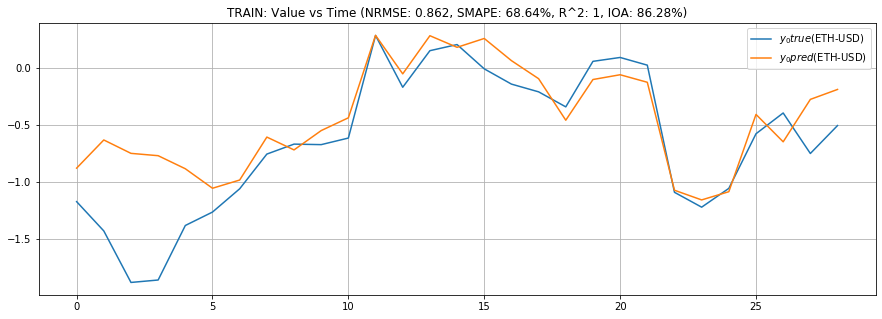

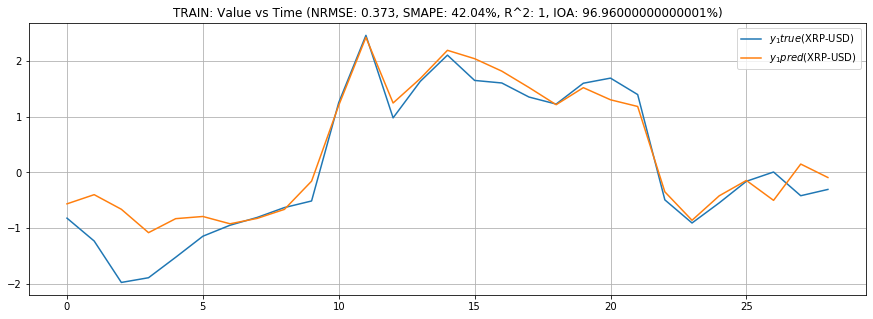

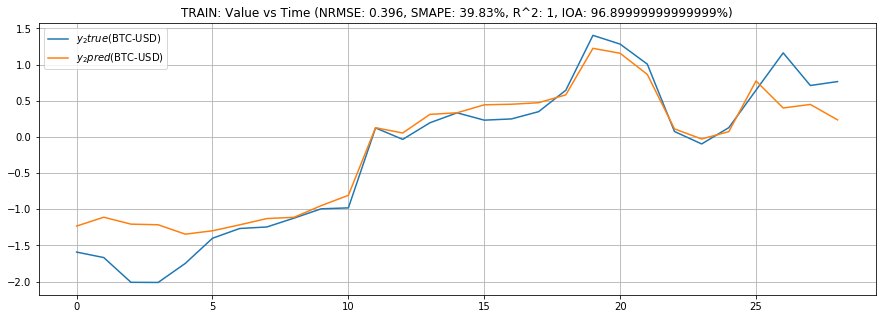

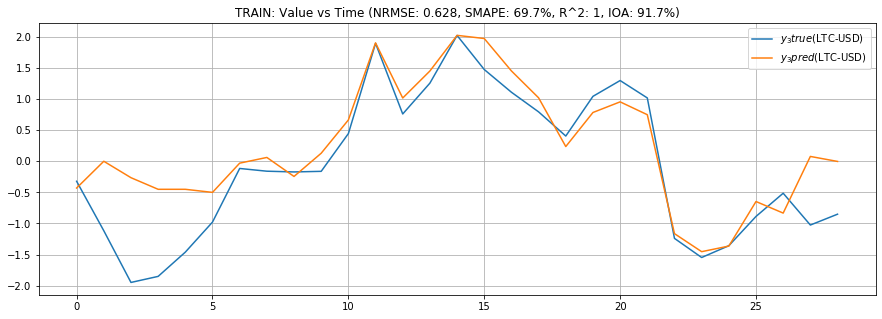

In [40]:
timesteps = data3_id.t.tolist()
for i in range(y_dimensions):    
    plt.figure(figsize=(15,5))
    # plt.plot(timesteps, data3_id.u[:,i,:][0].tolist(), label='$u_{:d}$({})'.format(i, u_labels[i]))   
    plt.plot(timesteps, data_y[i,:-1].tolist(), label='$y_{:d}true$({})'.format(i, y_labels[i]))         
    plt.plot(timesteps, data3_id.y[:,i,:][0].tolist(), label='$y_{:d} pred$({})'.format(i, y_labels[i]))
    plt.legend()
    plt.grid()
    
    plt.title("TRAIN: Value vs Time (NRMSE: {}, SMAPE: {}%, R^2: {}, IOA: {}%)".format(
        round(float(nrms(np.array(data_y[i, :-1]), np.array(data3_id.y[:,i,:][0]))), 3), 
        round(float(symmetric_mean_absolute_percentage_error(np.array(data_y[i, :-1]),np.array(data3_id.y[:,i,:][0]))), 2),
        # round(float(r2_score(data_y[i, :-1].tolist(), data3_id.y[:,i,:][0].tolist())), 2),
        1,
        100 * round(float(index_of_agreement(np.array(data_y[i, :-1]),np.array(data3_id.y[:,i,:][0]))), 4)
    ))

print("TRAIN: Total NRMSE: {}".format(round(float(nrms(np.array(data_y[:, :-1]),np.array(data3_id.y[0]))), 3)))
print("TRAIN: Total sMAPE: {}%".format(round(float(symmetric_mean_absolute_percentage_error(np.array(data_y[:, :-1]),np.array(data3_id.y[0]))), 2)))
print("TRAIN: Total IOA: {}%".format(100 * round(float(index_of_agreement(np.array(data_y[:, :-1]),np.array(data3_id.y[0]))), 4)))

In [41]:
def f_prbs_4d(t, x, i):
    return np.array([test_data_u[:, i]], dtype=numpy.float16).T

# TODO: test data here to simulate (should be similar)
data4_id = ss3_id.simulate(
    f_u=f_prbs_4d,
    x0=np.array([np.zeros(ss3_id.A.shape[0], dtype=numpy.float16)], dtype=numpy.float16).T,
    tf=tf)

TEST: Total NRMSE: 1.433
TEST: Total sMAPE: 133.71%
TEST: Total IOA: 66.67%


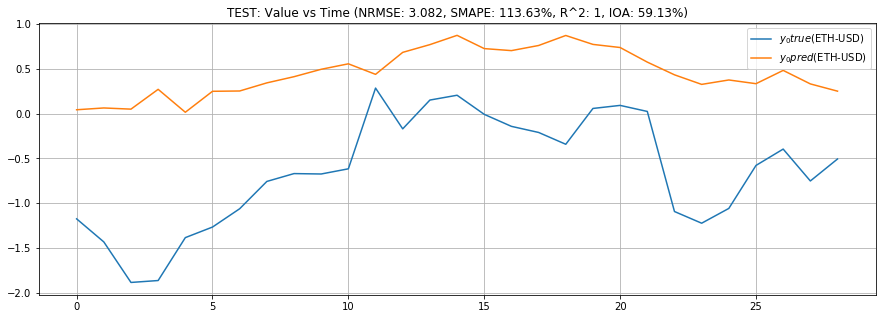

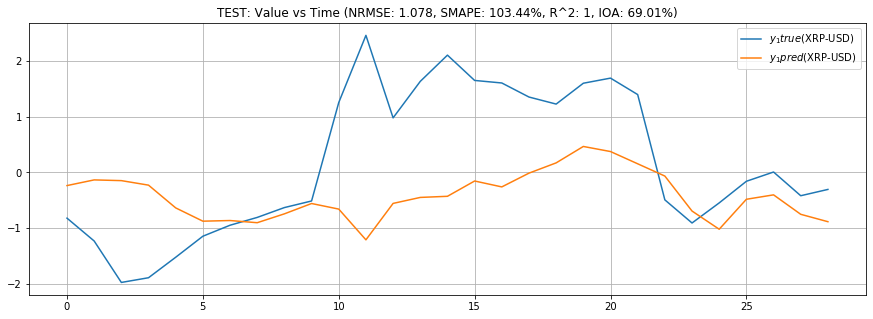

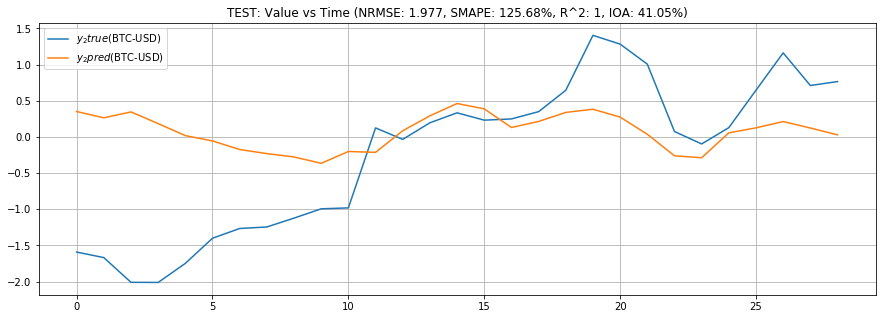

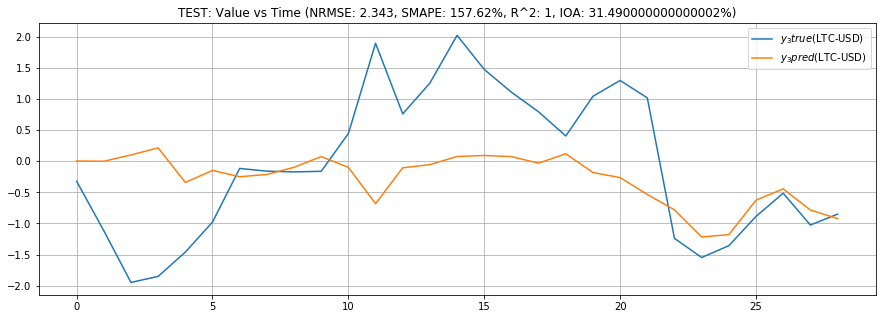

In [42]:
timesteps = data4_id.t.tolist()
for i in range(y_dimensions):    
    plt.figure(figsize=(15,5))
    # plt.plot(timesteps, data4_id.u[:,i,:][0].tolist(), label='$u_{:d}$({})'.format(i, u_labels[i]))   
    plt.plot(timesteps, data_y[i,:-1].tolist(), label='$y_{:d}true$({})'.format(i, y_labels[i]))         
    plt.plot(timesteps, data4_id.y[:,i,:][0].tolist(), label='$y_{:d} pred$({})'.format(i, y_labels[i]))
    plt.legend()
    plt.grid()
    
    plt.title("TEST: Value vs Time (NRMSE: {}, SMAPE: {}%, R^2: {}, IOA: {}%)".format(
        round(float(nrms(np.array(test_data_y[i, :-1]), np.array(data4_id.y[:,i,:][0]))), 3), 
        round(float(symmetric_mean_absolute_percentage_error(np.array(test_data_y[i, :-1]),np.array(data4_id.y[:,i,:][0]))), 2),
        # round(float(r2_score(test_data_y[i, :-1].tolist(), data4_id.y[:,i,:][0].tolist())), 2),
        1,
        100 * round(float(index_of_agreement(np.array(test_data_y[i, :-1]),np.array(data4_id.y[:,i,:][0]))), 4)
    ))

print("TEST: Total NRMSE: {}".format(round(float(nrms(np.array(test_data_y[:, :-1]),np.array(data4_id.y[0]))), 3)))
print("TEST: Total sMAPE: {}%".format(round(float(symmetric_mean_absolute_percentage_error(np.array(test_data_y[:, :-1]),np.array(data3_id.y[0]))), 2)))
print("TEST: Total IOA: {}%".format(100 * round(float(index_of_agreement(np.array(test_data_y[:, :-1]),np.array(data4_id.y[0]))), 4)))